<a href="https://colab.research.google.com/github/tithishah21/malaria-image-segmentation/blob/main/Microscopic_Counting_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PHASE 1 — DATASET UNDERSTANDING & SAMPLING**
Step 1.1 — Load and visualize images

*   Step 1.2 — Create a working subset (IMPORTANT)
*   Step 1.2 — Create a working subset (IMPORTANT)

**PHASE 2 — PREPROCESSING (OpenCV only)**
*  Step 2.1 — Convert color space
*  Step 2.2 — Noise reduction
*  Step 2.3 — Contrast enhancement (VERY IMPORTANT)
*   Step 2.4 — Thresholding
*   Step 2.5 — Morphological operations

**PHASE 3 — SEGMENTATION (CORE OF THE PAPER)**
*  Step 3.1 — Distance Transform
*  Step 3.2 — Foreground extraction
*  Step 3.3 — Marker creation
*  Step 3.4 — Watershed segmentation

**PHASE 4 — FEATURE EXTRACTION (VERY IMPORTANT)**
*   Step 4.1 — Extract contours
*   Step 4.2 — Shape features
*   Step 4.3 — Texture features (Haralick)
*   Step 4.4 — Create feature vector

**PHASE 5 — CLASSICAL ML CLASSIFICATION**
*   Step 5.1 — Train/Test split
*   Step 5.2 — Train classifiers
*   Step 5.3 — Evaluation

**PHASE 6 — FULL DATASET RUN**

**PHASE 7 — RESULTS & FIGURES (VERY IMPORTANT)**







### Project Step by Step Guide

## 1. Image Processing using OpenCV
  - Read image
  - Convert color space(for biological meaning try using HSV/LAB instead of gray since color carries biological meaning)
  - Noise reduction using blurring technique(gaussian blur / bilateral blur)
  - Contrast enhancement (using CLAHE)
  - Thresholding(binary and OTSU)
  - Morphological cleaning(removes small noise and smoothes object boundary)
  - WaterShed segmentation (to separate overlapping cells)
  link for watershed: https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html
    - distance transform,dilate etc
  
  ## 2. Feature Extraction

  - Convert cell masks -> meaningful numerical features

  - Shape features (OpenCV)

      Area

      Perimeter

      Circularity

      Aspect ratio

      Solidity

  - Intensity features (NumPy)

      Mean pixel intensity

      Std deviation

  - Texture features (skimage)

      GLCM contrast

      Homogeneity

      Energy

      Entropy
    
## Step 3: Dataset Formation and EDA

## Step 4: Baseline Model training(Logistic Regression, SVM and Random Forest) compare these with Ensemble Learning - Our core model (bagging and boosting)

## Step 5: HyperParameter Tuning using GridSearchCV

## Step 6: Final Evaluation using confusion matrix, feature importance plots and failure case visualization


### Step-1 : Image Processing
## below code is testing done by dipit.. can remove once we start doing the project

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

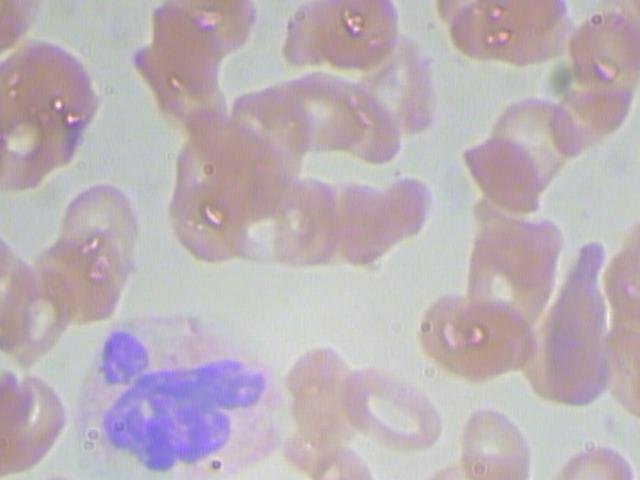

In [ ]:
img = cv.imread("BloodImage_00001.jpeg")
cv2_imshow(img)